T-Q диаграмма
Минимальный напор: 5.091734342656764 °С i = 34
Конец конденсации при i= 34
Qsumm = 11615451.985597048


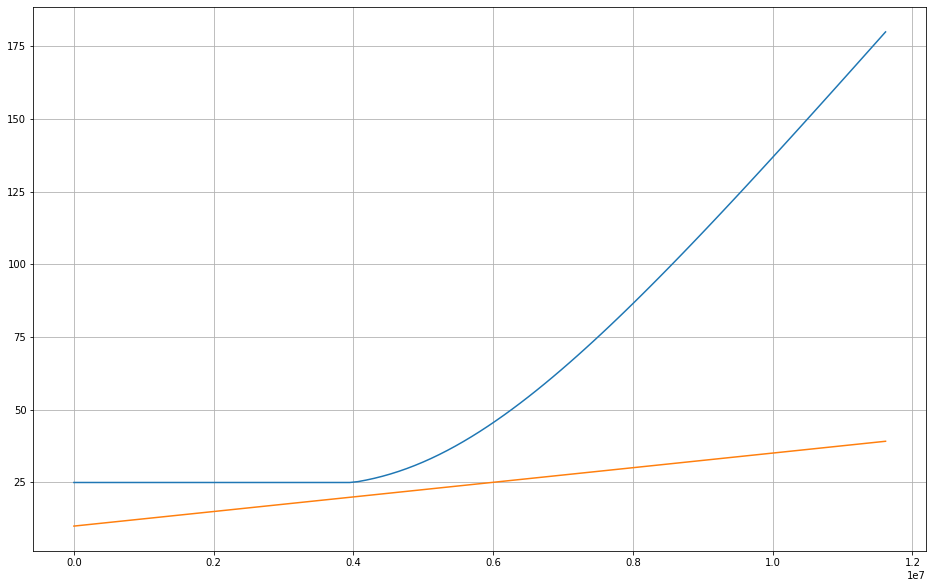

10.464522712077038
1657
0.9928000000000001 12.490996452864007


In [3]:
#Расчёт Конденсатора
import matplotlib.pyplot as pt
import numpy as n
import math as m
import json, CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI as p
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, 'C:\\maximov\\REFPROP\\')
from scipy.optimize import root

#исходные данные:
G1   = 33.338
G2   = 95.155
T11  = 180
T21  = 10       #В °С
P11  = 6434200  #В Па
P21  = 100000   #В Па
Qend = 0        #Конечная степень сухости


#Геометрия:
Dvnes = 0.017 #Внешний диаметр трубки https://docs.cntd.ru/document/1200001411
DeltaTube = 0.0022
DeltaKorp = 0.02
Dvnut = Dvnes-2*DeltaTube
steptube = Dvnes*1.2
w2out=0.5     #Скорость воды (меньше скорость - меньше L, но больше D, больше V)
lambdaw = 20


CO2  = 'REFPROP::CO2'
H2O  = 'REFPROP::WATER'
O2   = 'REFPROP::Oxygen'
H11  = p('H','T', T11+273.15, 'P', P11, CO2)
H12  = p('H','P', P11, 'Q', Qend, CO2)
H21  = p('H','T', T21+273.15, 'P', P21, H2O)


#Разбиение по энтальпии:
s    = 100 #Кол-во шагов
step = (H11-H12)/(s) 


#Нулевые массивы:
t1   = n.zeros(s+1)
t2   = n.zeros(s+1)
Q    = n.zeros(s+1)
F    = n.zeros(s+1)
L    = n.zeros(s+1)


#Противоток:
h11 = H12
h21 = H21
i=0
for i in range(s+1):
    t1[i] = p('T','H', h11, 'P', P11, CO2)-273.15
    t2[i] = p('T','H', h21, 'P', P21, H2O)-273.15    
    h12 = h11 + step
    dQ = G1 * (h12-h11)
    if i < s:
        Q[i+1]=Q[i]+dQ
    h22 = (dQ/G2)+h21
    h11 = h12
    h21 = h22
DT=t1-t2


#Определение индекса конца конденсации:
for i in range(s):
    if round(t1[i+1],9)-round(t1[i],9)>0:
        icond=i
        break;
#Вывод графика
print('T-Q диаграмма')
print('Минимальный напор:',min(DT),'°С', 'i =',n.argmin(DT))
print('Конец конденсации при i=',icond)
print('Qsumm =',Q[s])
x  = [Q[i] for i in range(s+1)]  
y1 = [t1[i] for i in (range(s+1))]
y2 = [t2[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x, y2)
pt.grid(True)
pt.show()


#Расчёт площади (K=const):
#F = n.zeros(s+1)
#for i in range(s):
#    K=1000
#    t1av = (t1[i]+t1[i+1])/2
#    t2av = (t2[i]+t2[i+1])/2
#    dT = t1av-t2av
#    dQ = Q[i+1]-Q[i]
#    dF = dQ/(K*dT)
#    F[i+1] = F[i]+dF


#Количество труб по диаметру:
ro22 = p('D','T', t2[s]+273.15, 'P', P21, H2O)
Fproh2 = G2/(w2out*ro22)
Ntubes = m.ceil(Fproh2/((n.pi*Dvnut**2)/4))
summ = 0
nd=0
n2 = 0
while n2 < Ntubes:
    summ = summ + nd
    n2=1+6*summ
    nd=nd+1
nd = 1+2*(nd-1)
Ntubes = n2
Dkorp = nd*steptube+2*Dvnes
Fproh1 = ((n.pi*Dkorp**2)/4)-(Ntubes*(n.pi*Dvnes**2)/4)


#Зона конденсации:
for i in range(icond):
    t1av = (t1[i]+t1[i+1])/2
    t2av = (t2[i]+t2[i+1])/2
    dT = t1av-t2av
    dQ = Q[i+1]-Q[i]
    ro1 = p('D','T', t1av+273.15, 'P', P11, CO2)
    nu1 = p('V','T', t1av+273.15, 'P', P11, CO2)/ro1
    Pr1 = p('PRANDTL','T', t1av+273.15, 'P', P11, CO2)
    lambda1 = p('L','T', t1av+273.15, 'P', P11, CO2)
    ro2 = p('D','T', t2av+273.15, 'P', P21, H2O)
    nu2 = p('V','T', t2av+273.15, 'P', P21, H2O)/ro2
    Pr2 = p('PRANDTL','T', t2av+273.15, 'P', P21, H2O)
    lambda2 = p('L','T', t2av+273.15, 'P', P21, H2O)
    w2 = G2/(ro2*Fproh2)
    Re2 = w2*Dvnut/nu2
    Nu2 = 0.021*Re2**0.8*Pr2**0.43
    def func(x):
        delta = 10**-5
        left = x
        right = 1/(2*n.log10((2.51/(Re2*(x)**(1/2)))+(delta/3.7)))**2
        return left-right
    sol = root(func, 0.01)
    f2=float(sol.x)
    alpha2 = Nu2*lambda2/Dvnut
    w1 = G1/(ro1*Fproh1)
    rol=p('D','T', t1av+273.15, 'Q', 0, CO2)
    rov=p('D','T', t1av+273.15, 'Q', 1, CO2)
    mul=p('V','T', t1av+273.15, 'Q', 0, CO2)
    lambdal = p('L','T', t1av+273.15, 'Q', 0, CO2)
    cpl = p('CPMASS','T', t1av+273.15, 'Q', 0, CO2)
    h = (p('H','P', P11, 'Q', 1, CO2)-p('H','P', P11, 'Q', 0, CO2) )*1000
    tw2 = (dQ*((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))+t2[i]+(dQ/alpha2)
    hfg = h+0.68*cpl*(t1[s]-tw2)
    alpha1 = 0.729*((9.81*rol*(rol-rov)*hfg*(lambdal**3)/(mul*(t1[s]-tw2)*Dvnes))**(1/4))
    K = 1/((1/alpha1)+(1/alpha2)+((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))
    dF = dQ/(K*(t1av-t2av))
    dL = dF/(n.pi*((Dvnes+Dvnut)/2)*Ntubes)
    F[i+1] = F[i]+dF
    L[i+1] = L[i]+dL



#Газовая зона:
for i in range(icond,s):
    t1av = (t1[i]+t1[i+1])/2
    t2av = (t2[i]+t2[i+1])/2
    dT = t1av-t2av
    dQ = Q[i+1]-Q[i]
    ro1 = p('D','T', t1av+273.15, 'P', P11, CO2)
    nu1 = p('V','T', t1av+273.15, 'P', P11, CO2)/ro1
    Pr1 = p('PRANDTL','T', t1av+273.15, 'P', P11, CO2)
    lambda1 = p('L','T', t1av+273.15, 'P', P11, CO2)
    ro2 = p('D','T', t2av+273.15, 'P', P21, H2O)
    nu2 = p('V','T', t2av+273.15, 'P', P21, H2O)/ro2
    Pr2 = p('PRANDTL','T', t2av+273.15, 'P', P21, H2O)
    lambda2 = p('L','T', t2av+273.15, 'P', P21, H2O)
    w2 = G2/(ro2*Fproh2)
    Re2 = w2*Dvnut/nu2
    Nu2 = 0.021*Re2**0.8*Pr2**0.43
    def func(x):
        delta = 10**-5
        left = x
        right = 1/(2*n.log10((2.51/(Re2*(x)**(1/2)))+(delta/3.7)))**2
        return left-right
    sol = root(func, 0.01)
    f2=float(sol.x)
    alpha2 = Nu2*lambda2/Dvnut
    w1 = G1/(ro1*Fproh1)
    Re1 = w1*Dvnes/nu1
    Nu1 = 0.22*(Re1**0.65)*(Pr1**0.36)
    alpha1 = Nu1*lambda1/Dvnes
    K = 1/((1/alpha1)+(1/alpha2)+((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))
    dF = dQ/(K*(t1av-t2av))
    dL = dF/(n.pi*((Dvnes+Dvnut)/2)*Ntubes)
    F[i+1] = F[i]+dF
    L[i+1] = L[i]+dL
V = ((n.pi*(Dkorp+2*DeltaKorp)**2)/4)*L[s]
print(V)
print(Ntubes)
print(Dkorp,L[s])